In [9]:
import yaml
import sys
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

import load_datasets
import fig_utils

In [10]:
base_dir = os.path.join('sl_results','23Aug22','1')
bulk_dir = os.path.join('sl_results','28Aug22','1')
sfai_dir = os.path.join('sl_results','28Aug22','1')

# plot type = '' (main text), _bulk, _sfai
plot_types = ['']

plot_type = ''

paths = []

for pt in plot_types:

    if pt == '':
        path_zt = os.path.join(base_dir,'starrydata_zt','starrydata_zt-1-496-55-{}-{}.csv')
        path_tc = os.path.join(base_dir,'starrydata_tc','starrydata_tc-1-496-55-{}-{}.csv')
        path_sigma = os.path.join(base_dir,'starrydata_sigma','starrydata_sigma-1-559-62-{}-{}.csv')
        
    if pt == '_bulk':
        path_zt = os.path.join(bulk_dir,'starrydata_zt_bulk','starrydata_zt_bulk-1-218-24-90-100.csv')
        path_tc = os.path.join(bulk_dir,'starrydata_tc_bulk','starrydata_tc_bulk-1-211-23-0-10.csv')
        path_sigma = os.path.join(bulk_dir,'starrydata_sigma_bulk','starrydata_sigma_bulk-1-234-26-90-100.csv')

    if pt == '_sfai':
        path_zt = os.path.join(sfai_dir,'starrydata_zt_sfai','starrydata_zt_sfai-1-524-58-90-100.csv')
        path_tc = os.path.join(sfai_dir,'starrydata_tc_sfai','starrydata_tc_sfai-1-518-57-0-10.csv')
        path_sigma = os.path.join(sfai_dir,'starrydata_sigma_sfai','starrydata_sigma_sfai-1-587-65-90-100.csv')

        
    paths.extend([path_zt, path_tc, path_sigma])
    
print(paths)


def get_heatmap_wrapper(path, n_targets):
    
    targets = [[0,10], [10,20], [20,30], [30,40], [40,50], [50,60], [60,70], [70,80], [80,90], [90,100]]

    fps = [path.format(target[0], target[1]) for target in targets]

    hx,hy,hz = fig_utils.get_DAF_heatmap_traces(fps, n_targets)

    return hx, hy, hz

# x, y, z = get_heatmap_wrapper(paths[0], 1)

['sl_results/23Aug22/1/starrydata_zt/starrydata_zt-1-496-55-{}-{}.csv', 'sl_results/23Aug22/1/starrydata_tc/starrydata_tc-1-496-55-{}-{}.csv', 'sl_results/23Aug22/1/starrydata_sigma/starrydata_sigma-1-559-62-{}-{}.csv']


In [11]:
def get_output_data(data_config_path):
    
    with open(r'{}.yaml'.format(data_config_path)) as file:
        data_config = yaml.load(file, Loader=yaml.FullLoader)

    dataset = data_config['dataset']
    output = data_config['output']

    if 'starrydata' in dataset:
        df = load_datasets.get_starrydata(out=output, composition_class=data_config['comp_class'], sample_form=data_config['sample_form'])
        df = df.reset_index()
        
    # df = featurize_composition(df, data_config['output'])
    df = load_datasets.group_and_index_formula(df, data_config['categoricals'], data_config['output'])
    
    return df, data_config


In [4]:
def add_quantile_traces(df, output, column):
    
    for q in np.arange(0,1, 0.1):
        q_min = q
        q_max = q+0.1

        q1_val = df[data_config['output']].quantile(q_min)
        q2_val = df[data_config['output']].quantile(q_max)

        if q_max*100 in [20, 60, 100]:

            fig.add_shape(type='line',
                            yref="y",
                            xref="x",
                            x0=q1_val,
                            y0=0,
                            x1=q1_val,
                            y1=100,
                            line=dict(color='black', width=2), row=1, col=column)  

            fig.add_annotation(x=q1_val, y=2.1,
                    text=round(q_min*100),
                    showarrow=False,
                    font=dict(size=16), row=1, col=column)


In [16]:
subplot_titles = ['(a) ZT', '(b) &#954;<sub>total</sub> (W/mK)', '(c)  log(&#963;<sub>E0</sub>) (S/m)',
                 '(d) DAF<sub>1</sub>','(e) DAF<sub>1</sub>','(f) DAF<sub>1</sub>',
                 '(g) DAF<sub>3</sub>','(h) DAF<sub>3</sub>','(i) DAF<sub>3</sub>',
                 '(j) DAF<sub>5</sub>','(k) DAF<sub>5</sub>','(l) DAF<sub>5</sub>',
                 ]

fig = make_subplots(
    rows=4, cols=3,
    shared_xaxes=True,
    vertical_spacing=0.1,
    print_grid=True,
    subplot_titles=subplot_titles
)
col = 1
color_vals = []
for path in paths:
    print('================{}================'.format(path))
    dataset_config_base_dir = os.path.join('configuration_files','dataset_configs')
    if 'zt' in path:
        data_config_path = os.path.join(dataset_config_base_dir,'starrydata_zt{}'.format(plot_type))
        prop = 'ZT (-)'
    if 'tc' in path:
        data_config_path = os.path.join(dataset_config_base_dir,'starrydata_tc{}'.format(plot_type))
        prop = '$\kappa_{total}$ (W/m*K)'
    if 'sigma' in path:
        data_config_path = os.path.join(dataset_config_base_dir,'starrydata_sigma{}'.format(plot_type))
        prop = '$\sigma_{E0}$ ()'

    print(data_config_path)

    df, data_config = get_output_data(data_config_path)
    print(prop, len(df))
    fig.add_trace(go.Histogram(x=df[data_config['output']], nbinsx=100), row=1, col=col)
    add_quantile_traces(df, data_config['output'], col)

    # tuple = (n_found, row to plot)
    for i in [(1,2) ,(3,3), (5,4)]:
        print(path)
        x, y, z = get_heatmap_wrapper(path, i[0])
        color_vals.extend(z)
        fig.add_trace(go.Heatmap(z=z, x=y, y=x, hoverongaps = False, coloraxis = "coloraxis"), row=i[1], col=col)

    fig.update_yaxes(type="log", row=1, col=col)
    fig.update_yaxes(title_text='Counts', range=[0,2.17], row=1, col=col)
#     fig.update_xaxes(title_text=prop, row=1, col=col)

    col += 1
    
color_vals = np.array(color_vals)
c_min = color_vals.min()
c_max = color_vals.max()

midpoint_color = ((1-c_min)/(c_max-c_min))

custom_balance_r= [
    [0.0, 'rgb(255, 150, 150)'],
    [midpoint_color, 'rgb(255,255,255)'],
    [1, 'rgb(69,117,180)']]


fig.update_layout(xaxis_showticklabels=True, xaxis2_showticklabels=True, xaxis3_showticklabels=True)
fig.update_layout(coloraxis = {'colorscale':custom_balance_r, 'colorbar':{'tickvals':[0,0.5,1,1.5,4], 'title':'DAF<sub>n</sub>'}})
fig.update_layout(font=dict(family="Barlow Semi Condensed", size=20), width=1200, height=900,  showlegend=False)
fig.write_image(os.path.join("static","fig5-DAF-starrydata{}.png".format(plot_type)), scale=2)


This is the format of your plot grid:
[ (1,1) x,y     ]  [ (1,2) x2,y2   ]  [ (1,3) x3,y3   ]
[ (2,1) x4,y4   ]  [ (2,2) x5,y5   ]  [ (2,3) x6,y6   ]
[ (3,1) x7,y7   ]  [ (3,2) x8,y8   ]  [ (3,3) x9,y9   ]
[ (4,1) x10,y10 ]  [ (4,2) x11,y11 ]  [ (4,3) x12,y12 ]

================sl_results/23Aug22/1/starrydata_zt/starrydata_zt-1-496-55-{}-{}.csv================
configuration_files/dataset_configs/starrydata_zt
ZT (-) 551
sl_results/23Aug22/1/starrydata_zt/starrydata_zt-1-496-55-{}-{}.csv
{'EV': (3.0, 1.9), 'EI': (2.8, 2.2), 'MU': (3.6, 2.6), 'Random': (9.5, 9.7)}
0-10 {'EV': (3.3, 2.1), 'EI': (3.6, 2.8), 'MU': (2.8, 2.0), 'Random': (1.1, 1.1)}
{'EV': (2.8, 2.1), 'EI': (2.9, 3.6), 'MU': (28.5, 11.7), 'Random': (8.1, 6.7)}
10-20 {'EV': (3.6, 2.7), 'EI': (3.4, 4.3), 'MU': (0.4, 0.1), 'Random': (1.2, 1.0)}
{'EV': (7.7, 6.4), 'EI': (5.5, 6.3), 'MU': (3.9, 2.5), 'Random': (10.1, 8.8)}
20-30 {'EV': (1.3, 1.1), 'EI': (1.8, 2.1), 'MU': (2.6, 1.6), 'Random': (1.0, 0.9)}
{'EV': (5.8, 4.5), 'EI': (

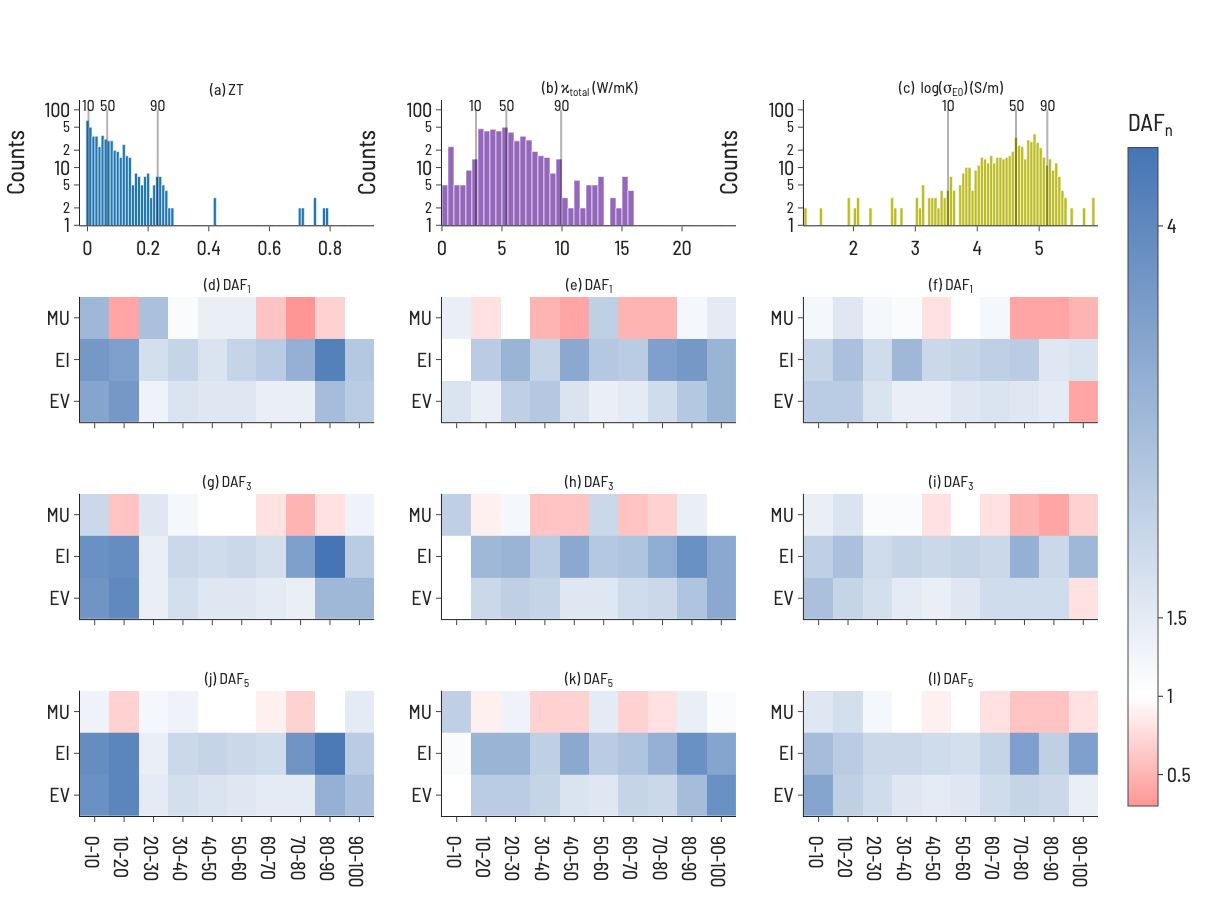

In [17]:
fig.show()